# import for future compatities

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import tensorflow as tf
import math
import numpy as np
import collections

In [3]:
import os
from six.moves import urllib
import zipfile
import random

# Download Data

In [4]:
#see is the file exsits
#if not, download the data
url = 'http://mattmahoney.net/dc/'
filename = 'text8.zip'
expected_size = 31344016
if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url+filename, filename)
statinfo = os.stat(filename)
if statinfo.st_size == expected_size:
    print("Found and verified")
else:
    raise Exception("Failed to download the correct file")

Found and verified


# Read Data

In [5]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [6]:
words = read_data(filename)
print('Data size', len(words))

Data size 17005207


# Build the Dictionary

In [7]:
vocabulary = 50000

In [8]:
words_counter = collections.Counter(words)

In [9]:
print(type(words_counter.most_common(2)[1]))

<type 'tuple'>


In [10]:
count = [['UNK', -1]]
count.extend(words_counter.most_common(vocabulary-1))

In [11]:
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [50]:
print(dictionary['america'])
print(dictionary['washington'])
print(dictionary['china'])
print(dictionary['beijing'])

357
933
486
3880


In [13]:
print(len(reverse_dictionary))

50000


### define some parameters

In [14]:
data_index = 0

### generate a string batch for the skip-gram model

In [15]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        #print(data_index)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                #print(span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [16]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

In [17]:
print(labels)

[[5239]
 [  12]
 [   6]
 [3084]
 [ 195]
 [  12]
 [   2]
 [   6]]


In [18]:
print(batch)
print(labels)
print(data[0:10])
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
    '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

[3084 3084   12   12    6    6  195  195]
[[5239]
 [  12]
 [   6]
 [3084]
 [ 195]
 [  12]
 [   2]
 [   6]]
[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
3084 originated -> 5239 anarchism
3084 originated -> 12 as
12 as -> 6 a
12 as -> 3084 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [19]:
vocabulary_size = 50000
embedding_size = 128
batch_size = 128
skip_window = 1
num_skips = 2

### Placeholders for inputs

## shape????

## Compute the NCE loss, use a sample of negative labels

In [20]:
num_sampled = 96
valid_windows = 100
valid_size = 16
valid_examples = np.random.choice(valid_windows, valid_size, replace=True)

In [126]:
with tf.Graph().as_default():
    with tf.device('/cpu:0'):
        #define the variables
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                  stddev=1.0 / math.sqrt(embedding_size)))
        nce_bias = tf.Variable(tf.zeros([vocabulary_size]))
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_bias,
                                         embed, train_labels, 
                                         num_sampled=num_sampled, num_classes=vocabulary_size))
        ## we use the SGD optimizer
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        ##
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_examples)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
        sess = tf.Session()
        sess.run(tf.initialize_all_variables())
        print('Initialized')
        average_loss = 0
        for step in range(100000):
            batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
            feed_dict = {train_inputs:batch_inputs, train_labels:batch_labels}
            _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += loss_val
            #print(average_loss)
            if step % 2000 == 0:
                print( average_loss/step)
            '''
            if step % 10000 == 0:
                print(valid_examples)
                sim = sess.run([similarity], feed_dict=feed_dict)
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 
                    #print(np.shape(sim))
                    nearest = (-sim[0][i, :]).argsort()[0:top_k]
                    for k in range(top_k):
                        valid_word += (reverse_dictionary[nearest[k]] + ' ')
                    print(valid_word)
            '''
        final_embeddings = sess.run([embeddings], feed_dict=feed_dict)
        

Initialized


/home/wang/tensorflow_dl/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


inf
115.068167865
83.6179248681
66.9447342902
56.0786329893
48.2876450304
42.4821332638
38.0695111019
34.5908544001
31.7312360575
29.3549734029
27.3504825759
25.6364364984
24.1572679242
22.8772508045
21.7643632642
20.7702665079
19.8860322283
19.1214493747
18.4048989637
17.7588911891
17.166902059
16.6159151857
16.121060585
15.6710041187
15.2544116335
14.8688300517
14.5060502849
14.1698119134
13.8489060395
13.551335116
13.2762290581
13.0143410204
12.7696619672
12.5389275596
12.3190395676
12.1117256077
11.9145234675
11.7270932264
11.5441700425
11.3737179125
11.211771
11.0577026895
10.910595845
10.7682638128
10.6313965018
10.4936552201
10.3659516745
10.2423722443
10.1261061204


In [127]:
nemb = sess.run([normalized_embeddings], feed_dict=feed_dict)

In [128]:
print(nemb)

[array([[-0.07730991, -0.08787166, -0.11851177, ...,  0.03924257,
         0.09078696, -0.11110268],
       [-0.13044176, -0.06287125, -0.01688294, ...,  0.09277652,
         0.00787201, -0.16822299],
       [-0.05109752, -0.07891434,  0.00680385, ...,  0.07129974,
         0.10060094,  0.00877671],
       ..., 
       [-0.08709569,  0.0069192 ,  0.04095519, ...,  0.12596177,
        -0.07673747, -0.04266592],
       [-0.0327139 , -0.02875558, -0.00057416, ...,  0.11964083,
        -0.06669596,  0.0569288 ],
       [-0.09281627,  0.01607427, -0.1310776 , ...,  0.11025514,
        -0.00603473, -0.00349796]], dtype=float32)]


In [129]:
print(final_embeddings[0].shape)

(50000, 128)


In [130]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',va='bottom')

In [131]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
except ImportError:
    print('Please install sklearn and matplotlib')
%matplotlib inline

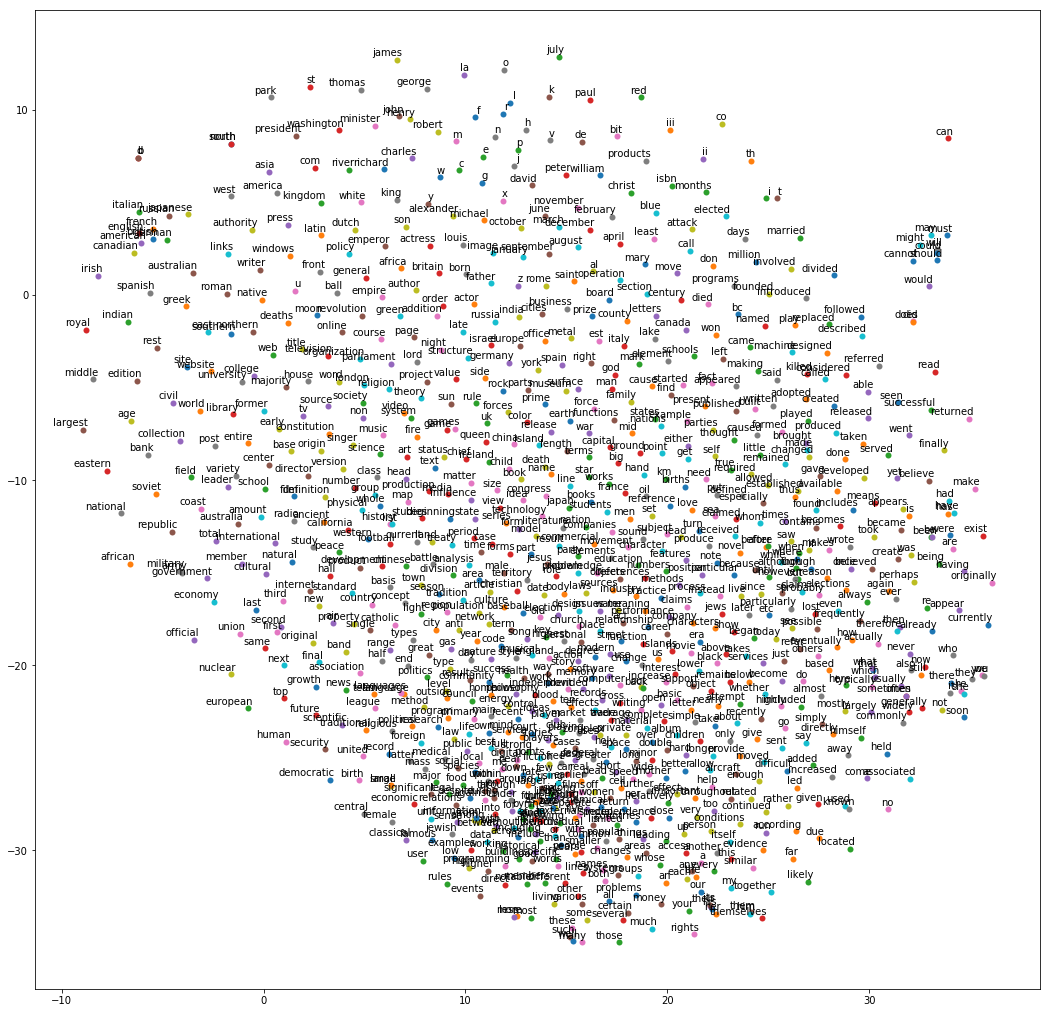

In [132]:
tsne = TSNE(n_components=2, init='pca', n_iter=5000)
plot_number = 1000
low_dim_embeddings = tsne.fit_transform(final_embeddings[0][:plot_number, :])
labels = [reverse_dictionary[i] for i in xrange(plot_number)]
plt.figure(figsize=(18,18))
plot_with_labels(low_dim_embeddings, labels )

# Evaluate the model

In [142]:
with tf.Graph().as_default(), tf.Session() as sess:
    a_emb = tf.gather(nemb[0], 36)
    b_emb = tf.gather(nemb[0], 243)
    c_emb = tf.gather(nemb[0], 169)
    target = c_emb + (a_emb - b_emb)
    target = tf.reshape(target, [1,128])
    dist = tf.matmul(target, nemb[0], transpose_b=True)
    _, pred_id = tf.nn.top_k(dist, 6,sorted=True)
    result = sess.run(pred_id)
    print(result[0])
    for i in result[0]:
        print(reverse_dictionary[i])

[ 36 169  47  27  60  57]
he
she
they
it
there
who


In [139]:
print(dictionary['he'])
print(dictionary['his'])
print(dictionary['she'])
print(dictionary['her'])
print('\n')
print(dictionary['he'])
print(dictionary['man'])
print(dictionary['she'])
print(dictionary['woman'])
print(reverse_dictionary[50])

36
30
169
111


36
243
169
1014
all


In [68]:
print(nemb[0].shape)
357
933
486
3880

(50000, 128)


3880

In [ ]:
print(sess.run(dist))

In [ ]:
print()

In [73]:
help(tf.nn.top_k)

Help on function top_k in module tensorflow.python.ops.nn_ops:

top_k(input, k=1, sorted=True, name=None)
    Finds values and indices of the `k` largest entries for the last dimension.
    
    If the input is a vector (rank-1), finds the `k` largest entries in the vector
    and outputs their values and indices as vectors.  Thus `values[j]` is the
    `j`-th largest entry in `input`, and its index is `indices[j]`.
    
    For matrices (resp. higher rank input), computes the top `k` entries in each
    row (resp. vector along the last dimension).  Thus,
    
        values.shape = indices.shape = input.shape[:-1] + [k]
    
    If two elements are equal, the lower-index element appears first.
    
    Args:
      input: 1-D or higher `Tensor` with last dimension at least `k`.
      k: 0-D `int32` `Tensor`.  Number of top elements to look for along the last
        dimension (along each row for matrices).
      sorted: If true the resulting `k` elements will be sorted by the values in